## Pre-Requisites

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pip install git+https://github.com/fbcotter/pytorch_wavelets

  Cloning https://github.com/fbcotter/pytorch_wavelets to /tmp/pip-req-build-4ja7day4
  Running command git clone --filter=blob:none --quiet https://github.com/fbcotter/pytorch_wavelets /tmp/pip-req-build-4ja7day4
  Resolved https://github.com/fbcotter/pytorch_wavelets to commit 9a0c507f04f43c5397e384bb6be8340169b2fd9a
  Preparing metadata (setup.py) ... done


In [ ]:
pip install hyde-images

## Import Dependencies

In [ ]:
import numpy as np
import hyde
import torch
import cv2
import PIL
from PIL import Image as im

def tensorToImageConversion(Tensor):
    Tensor = np.array(Tensor, dtype=np.uint8)
    if np.ndim(Tensor)>3:
        assert Tensor.shape[0] == 1
        Tensor = Tensor[0]
    return PIL.Image.fromarray(Tensor)

directory = '/content/drive/MyDrive/RGamma/M3G20090606T093322_V01_L2_8.tif'
input = cv2.imread(directory)
input_tens = torch.tensor(input, dtype=torch.float32)

## [`HyRes`](https://doi.org/10.1109/LGRS.2017.2764059) Overview

1.   **Background**: The paper addresses the challenge of restoring hyperspectral images, which are captured across numerous spectral bands and are often affected by noise, atmospheric disturbances, and other degradations. The restoration process aims to improve the quality of these images for various applications in remote sensing and related fields.

2.   **Approach**: The researchers propose an automatic restoration algorithm that leverages both sparse and low-rank modeling techniques. Sparse modeling focuses on capturing the significant spectral features in the data by representing it using a small number of non-zero coefficients. Low-rank modeling, on the other hand, aims to capture the common underlying structure or patterns across different spectral bands.

3.   **Integration of Sparse and Low-Rank Modeling**: The novelty of the proposed algorithm lies in its integration of sparse and low-rank modeling approaches. By combining the advantages of both techniques, the algorithm can effectively exploit the sparsity and low-rankness properties inherent in hyperspectral data, leading to enhanced restoration results.

4.   **Methodology**: The paper provides details about the specific methodology used for the automatic restoration algorithm. It describes how the algorithm detects and utilizes the sparse and low-rank properties of the hyperspectral data. This involves extracting and modeling the sparse coefficients and exploiting the low-rankness in the data through suitable optimization techniques.

5.   **Experimental Results**: The researchers conducted experiments to evaluate the performance of the proposed algorithm. Real-world hyperspectral images were used to assess the restoration quality. The results demonstrated significant improvements in denoising, reconstruction, and preservation of spectral details compared to existing restoration methods. The algorithm showed robustness and effectiveness in restoring the quality of hyperspectral images, which is crucial for accurate analysis and interpretation of remote sensing data.

6.   **Implications and Significance**: The paper's findings have important implications for the field of remote sensing and hyperspectral image processing. The proposed algorithm offers an automated solution for enhancing the quality and usability of hyperspectral images, providing valuable insights for various applications, such as environmental monitoring, agriculture, and urban planning.

7.   **Future Directions**: The research paper may also discuss potential future directions or areas of improvement. This could include exploring advanced optimization techniques, addressing specific challenges in hyperspectral image restoration, or considering the integration of additional modeling approaches for further performance enhancement.

## [`HyRes`](https://doi.org/10.1109/LGRS.2017.2764059) Implementation

https://colab.research.google.com/drive/1Aw_qtnYXhN3RWbNBpMpxdqCSKGxUfvFn?usp=sharing

```
import torch

from hyde.lowlevel import dwt3d, utils

__all__ = ["HyRes"]


class HyRes(torch.nn.Module):

    '''
    HyRes -- Automatic Hyperspectral Restoration Using low-rank and sparse modeling.

    The model used is :math:`Y=D_2XV'+N` and penalized least squares with :math:`\ell_1` penalty.
    The formula to restore the signal is:

    .. math::
    
          argmax(0.5 * ||Y-D_2XV'||_F^2+\lambda||X||_1)
        

    This method relies on Daubechies wavelets for wavelet decomposition

    Parameters
    ----------
    decomp_level : int, optional
        the level of the wavelet decomposition to do
        default: 5
    wavelet_level : int, optional
        the integer value indicating which Daubechies wavelet to use. i.e. 5 -> db5
        default: 5
    padding_method : str, optional
        the method used to pad the image during the DWT transform.
        options: [zero, symmetric, periodization, reflect, periodic]
        default: "symmetric"

    Notes
    -----
    Algorithmic questions should be forwarded to the original authors. This is purely an
    implementation of the algorithm detailed in [1].

    References
    ----------
    [1] B. Rasti, M. O. Ulfarsson and P. Ghamisi, "Automatic Hyperspectral Image Restoration
    Using Sparse and Low-Rank Modeling," in IEEE Geoscience and Remote Sensing Letters, vol. 14,
    no. 12, pp. 2335-2339, Dec. 2017, doi: 10.1109/LGRS.2017.2764059.

    '''

    def __init__(self, decomp_level=5, wavelet_level=5, padding_method="symmetric", device="cpu"):
        super(HyRes, self).__init__()
        self.decomp_level = decomp_level  # L
        self.wavelet_name = "db" + str(wavelet_level)
        self.device = device

        self.padding_method = padding_method

        self.dwt_forward = dwt3d.DWTForwardOverwrite(
            self.decomp_level,
            self.wavelet_name,
            self.padding_method,
            device=self.device,
        )
        self.dwt_inverse = dwt3d.DWTInverse(
            wave=self.wavelet_name, padding_method=self.padding_method, device=self.device
        )

    def forward(self, x: torch.Tensor, min_iter: int = 2):
        """
        Denoise an image `x` using the HyRes algorithm.

        Parameters
        ----------
        x: torch.Tensor
            input image
        min_iter : int, optional
            minimum number of iterations to run for until breaking the denoising loop

        Returns
        -------
        denoised_image : torch.Tensor
        """
        self.device = x.device
        # need to have the dims be (num images (1), C_in, H_in, W_in) for twave ops
        # current order: rows, columns, bands (H, W, C) -> permute tuple (2, 0, 1)
        og_rows, og_cols, og_channels = x.shape
        two_d_shape = (og_rows * og_cols, og_channels)
        # current shape: h x w X c
        # current shape: w x h X c -> unclear why this needs to be this way...
        w, _ = utils.estimate_hyperspectral_noise(
            x.reshape(two_d_shape).T,
            calculation_dtype=torch.float64,
        )

        # padd to make things even
        if og_rows % (2 ** self.decomp_level) != 0:
            x = utils.symmetric_pad(
                x,
                [
                    0,
                    0,
                    0,
                    2 ** self.decomp_level - (og_cols % 2 ** self.decomp_level),
                    0,
                    2 ** self.decomp_level - (og_rows % 2 ** self.decomp_level),
                ],
            )
        padded_shape = tuple(x.shape)

        p_rows, p_cols, p_ch = x.shape
        eps = 1e-30
        omega1 = (torch.sqrt(torch.var(w, dim=1)) + eps) ** 2
        # estimate the noise with the standard deviation? (unsure about if that is whats happening)
        omega1 = omega1.reshape((1, 1, omega1.numel())).repeat(p_rows, p_cols, 1)
        y_w = torch.pow(omega1, -0.5) * x
        # do PCA and combine a couple things (see function)
        v_pca, pc = utils.custom_pca_image(y_w)
        # do wavelet decomp
        # next is twoDWTon3Ddata -> requires permute + unsqueeze
        pc = pc.to(torch.float)  # no-op if already float
        # pc -> h x w x c
        v_dwt_full, v_dwt_lows, v_dwt_highs = self.dwt_forward.forward(
            pc.permute((2, 0, 1)).unsqueeze(0)
        )
        # remove NaNs with max/min values, Nan -> 0
        v_dwt_lows = torch.nan_to_num(v_dwt_lows, nan=0, posinf=x.max(), neginf=x.min())
        for c in range(len(v_dwt_highs)):
            v_dwt_highs[c] = torch.nan_to_num(v_dwt_highs[c], nan=0, posinf=x.max(), neginf=x.min())

        v_dwt_permed, v_dwt_filter_starts = dwt3d.construct_2d_from_filters(
            low=v_dwt_lows, highs=v_dwt_highs
        )

        norm_v_dwt = torch.linalg.norm(v_dwt_permed) ** 2
        n_xyz = v_dwt_permed.numel()
        sure, min_sure = None, []
        rank = None
        for rank in range(og_channels):
            sure_i, thresh_i, t1, min_sure_i = utils.sure_soft_modified_lr2(v_dwt_permed[:, rank])
            if thresh_i != 0:
                v_dwt_permed[:, rank] = utils.soft_threshold(v_dwt_permed[:, rank], thresh_i)

            if sure is None:
                sure = sure_i.unsqueeze(1)
            else:
                sure = torch.cat([sure, sure_i.unsqueeze(1)], dim=1)

            sure[:, rank] = torch.sum(sure, dim=1) + norm_v_dwt - n_xyz
            min_sure_h = torch.min(sure[:, rank])
            min_sure.append(min_sure_h)
            if rank > min_iter and not min_sure[rank] > min_sure[rank - 1] * 2:
                break

        inv_lows = v_dwt_lows[:, :rank]
        inv_highs = [asdf[:, :rank] for asdf in v_dwt_highs]
        y_est_sure_model_y = self.dwt_inverse((inv_lows, inv_highs))

        # y_est_sure_model_y -> n x c x h x w  -> perm back: squeeze -> 1, 2, 0 (h, w, c)
        y_est_sure_model_y = y_est_sure_model_y.squeeze().permute((1, 2, 0))
        y_est_sure_model_y = y_est_sure_model_y.reshape((padded_shape[0] * padded_shape[1], rank))
        if y_est_sure_model_y.dtype != x.dtype:
            y_est_sure_model_y = y_est_sure_model_y.to(x.dtype)

        # ------ inverse PCA stuff -----------------------
        y_restored = (omega1 ** 0.5) * torch.matmul(y_est_sure_model_y, v_pca[:rank, :]).reshape(
            padded_shape
        )
        return y_restored[:og_rows, :og_cols, :og_channels]

```



In [ ]:
mix = hyde.HyRes()
output = mix(input_tens)

## O/P HSI

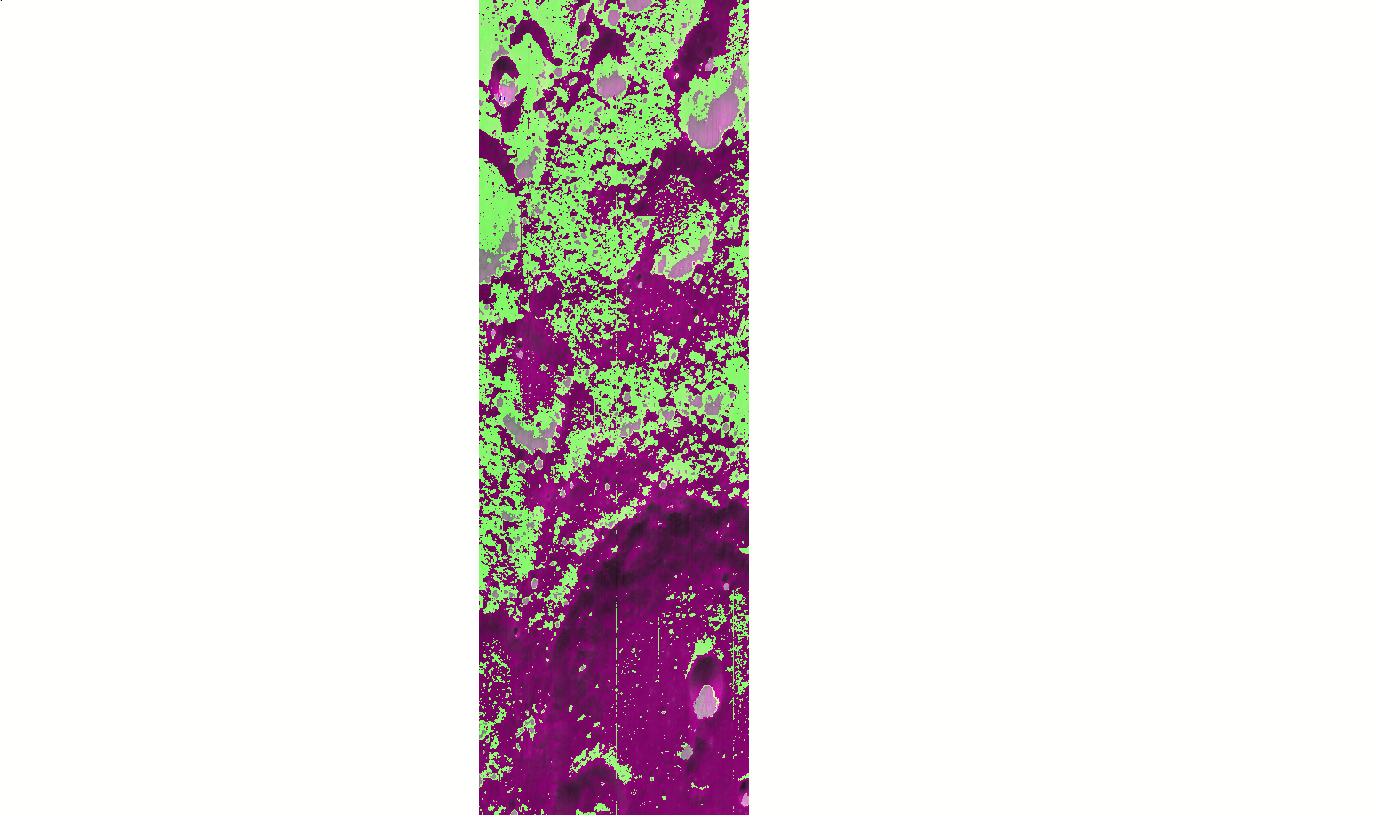

In [ ]:
tensorToImageConversion(output)